# Ground Truth

## Overview

In this study, we investigate the potential of Sentinel-2 Level-2A data for classifying evergreen leafs of forests in temperate climates. We begin with processing the ground truth data before performing any experiments.

In this Jupyter Notebook we inspect the ground truth data, generate the target rasters and compare Sentinel-2 Level-1C data with Level-2A data.

## How To Run

Please refer to the REAMDE.md file in this repository for a tutorial on how to set up [GEE](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api). Additionally you need a dataset of CSV files in `../data/interim/train/` as well as in `../data/interim/test/`. These CSV files should contain following columns:
```python
"genus": str  # Tree genus
"date": str  # Date in YYYY-MM-DD format
"dbh": 0 < float  # DBH in meters
"latitude": float
"longitude": float
```
You can use the dataset inside the `train` folder but need to provide your own `test` dataset. Then you can run the notebook using Run All in your IDE.

## Target Preprocessing

The target rasters in the `train` folder are computed from representation areas for bavarian natural forest reserves. The target raster used as `test` set is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31) and follow above CSV format to generate the target raster.

We load the train set and filter it by date:

In [1]:
# Load the data and convert it to a GeoDataFrame
from logging import INFO
from pathlib import Path
from sys import stdout

import geopandas as gpd
import pandas as pd
from loguru import logger

logger.configure(handlers=[{"sink": stdout, "format": "{message}", "level": INFO}])

example_path = Path("../data/interim/train/95.csv")
example = pd.read_csv(example_path, parse_dates=["date"])

data = example.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(example["longitude"], example["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

logger.info("Data types per column:\n")
logger.info(gdf.dtypes)

Data types per column:

genus               object
date        datetime64[ns]
dbh                float64
geometry          geometry
dtype: object


  0%|          | 0/90 [00:00<?, ?it/s]

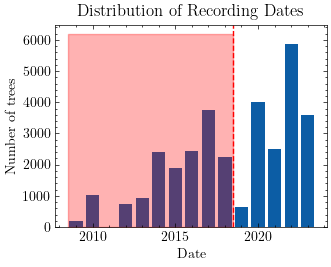

In [2]:
# Plot the distribution of the recording dates
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots  # noqa: F401
from tqdm.notebook import tqdm

from slc.visualize import save_fig

plt.style.use("science")

csv_paths = list(Path("../data/interim/train/").glob("*.csv"))
dates = []
for path in tqdm(csv_paths):
    example = pd.read_csv(path, parse_dates=["date"])
    dates.extend(example["date"])

date_threshold = 2018.5

fig, ax = plt.subplots()
series = pd.Series(dates).dt.year.value_counts()
series = series.reindex(range(series.index.min(), series.index.max() + 1), fill_value=0)
plt.bar(series.index, series.values)

ax.set_title("Distribution of Recording Dates")
ax.set_xlabel("Date")
ax.set_ylabel("Number of trees")

ax.fill_betweenx(
    ax.get_ylim(), date_threshold, series.index.min() - 0.5, color="red", alpha=0.3
)
ax.axvline(date_threshold, color="red", linestyle="--")

save_fig(fig, f"../reports/figures/ground_truth/{ax.get_title()}.svg")

As we use Sentinel-2 Level-2A data for our study, the first year covered completely by satellite data is [2018](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED). We filter the data to only include data collected from 2019 onwards, as we want the satellite imagery from the year the data was collected and the year 2018 is reserved for the test set. This does reduce the dataset significantly but ensures high quality data for our study and the ability to demonstrate the ability to generalize across time. Additionally, we exclude all study areas with data spanning multiple years and convert the remaining areas to rasters using the Google Earth Engine API.

The plot data is converted to a raster with a resolution of 10 meters and the appropriate UTM coordinate reference system projection as the Sentinel-2 data. See [Sentinel-2 User Handbook](https://sentinel.esa.int/documents/247904/685211/Sentinel-2_User_Handbook) page 9 and 36. The resulting target rasters contain the base area per genus as channels:

In [3]:
# Convert the data to two rasters
from slc.data import compute_target

FIRST_YEAR = 2019

gt_path = Path("../data/processed/")
gt_path.mkdir(parents=True, exist_ok=True)

total = 0

target_paths = []
for path in tqdm(csv_paths):
    example = pd.read_csv(path, parse_dates=["date"])

    if len(example) == 0:
        logger.debug(f"Skipping {path} as it is empty")
        continue

    if example.isna().any(axis=None):
        logger.debug(f"Skipping {path} as it contains missing values")
        continue

    dates = example["date"].unique()
    if len(dates) > 1:
        logger.debug(f"Skipping {path} as data was collected in multiple years")
        continue

    year = dates[0].year
    if year < FIRST_YEAR:
        logger.debug(
            f"Skipping {path} as data was collected in {year}. Level-2A data covers all years fully starting at {FIRST_YEAR}."
        )
        continue

    total += len(example)

    area_id = Path(path).stem
    target_path = gt_path / f"target/{area_id}_{year}.tif"
    if not target_path.exists():
        target_path.parent.mkdir(parents=True, exist_ok=True)
        compute_target(target_path=target_path, plot=example)

    target_paths.append(target_path)

logger.info(f"Total number of trees: {total}")
logger.info(f"Number of target rasters: {len(target_paths)}")

  0%|          | 0/90 [00:00<?, ?it/s]

Total number of trees: 16162
Number of target rasters: 48


After selecting the areas, our dataset consists of 17938 trees distributed over 51 areas. To visualize the conversion to raster format, we plot the tree level data of the CSV file and a processed version of the raster data:

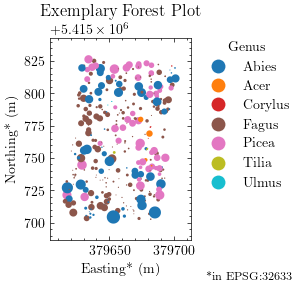

In [4]:
# Plot the data on stem level
from pathlib import Path

import matplotlib.pyplot as plt

gdf_buffer = gdf.copy()
gdf_buffer["geometry"] = gdf_buffer["geometry"].buffer(gdf_buffer["dbh"] * 5)

# Plot
fig, ax = plt.subplots()
golden_ratio = (1 + 5**0.5) / 2
ax = gdf_buffer.plot(
    column="genus",
    legend=True,
    legend_kwds={
        "title": "Genus",
        "loc": "center left",
        "bbox_to_anchor": (1, 1 / golden_ratio),
    },
    ax=ax,
)

ax.margins(x=0.1, y=0.1)

# Format
ax.set_title("Exemplary Forest Plot")
ax.set_xlabel("Easting* (m)")
ax.set_ylabel("Northing* (m)")
ax.annotate(
    "*in EPSG:32633",
    (ax.get_position().x1, 0),
    xycoords="figure fraction",
    va="bottom",
    ha="center",
    fontsize="small",
)

save_fig(fig, f"../reports/figures/ground_truth/{ax.get_title()}.svg")

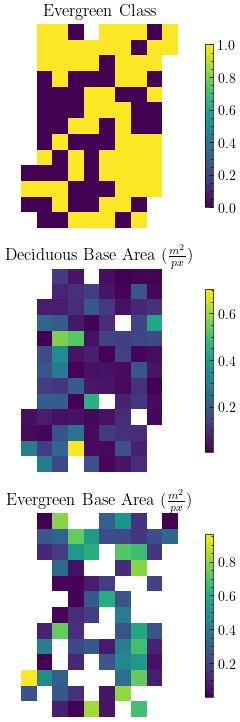

In [5]:
# Plot the two rasters, plot the base area separately per leaf type
import numpy as np
import rasterio

from slc.features import genera2target, load_raster

year = example = pd.read_csv(example_path, parse_dates=["date"])[
    "date"
].dt.year.unique()[0]
raster_path = gt_path / "target" / f"{example_path.stem}_{year}.tif"
example_raster = load_raster(raster_path)
example_classification = genera2target(example_raster)
example_regression = genera2target(example_raster, regression=True)

with rasterio.open(raster_path) as src:
    shape = src.shape

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

# Plot the conifer content
target = example_classification.map({"deciduous": 0, "evergreen": 1}).astype(float)
target = target.to_numpy().reshape(shape)
shape = target.shape

norm = plt.Normalize(vmin=0, vmax=1)
img = axes[0].imshow(target, cmap="viridis", norm=norm, interpolation="nearest")
axes[0].set_title("Evergreen Class")
axes[0].axis("off")

fig.colorbar(img, shrink=0.8)

# Plot the broadleaf area
deciduous_area = example_regression["deciduous"].to_numpy().reshape(shape)
deciduous_area[deciduous_area == 0] = np.nan

img = axes[1].imshow(deciduous_area, cmap="viridis", interpolation="nearest")
axes[1].set_title(r"Deciduous Base Area ($\frac{m^2}{px}$)")
axes[1].axis("off")

fig.colorbar(img, shrink=0.8)

# Plot the evergreen area
evergreen_area = example_regression["evergreen"].to_numpy().reshape(shape)
evergreen_area[evergreen_area == 0] = np.nan

img = axes[2].imshow(evergreen_area, cmap="viridis", interpolation="nearest")
axes[2].set_title(r"Evergreen Base Area ($\frac{m^2}{px}$)")
axes[2].axis("off")

fig.colorbar(img, shrink=0.8)

save_fig(fig, f"../reports/figures/ground_truth/{ax.get_title()}.svg")

For classification we divide each genus into two classes: evergreen and deciduous. The base area per class is used to determine the dominant leaf class for each pixel. The resulting target rasters are stored in the `../data/processed/target` folder.

The dataset is biased towards deciduous trees, as they are more common in natural forest reserves in the temperate climate of Bavaria. To gain insights into the distribution of the different classes and genera, we plot the distribution of the classes and genera in the dataset. For a nuanced presentation we use a logarithmic scale for the second plot:

  0%|          | 0/48 [00:00<?, ?it/s]

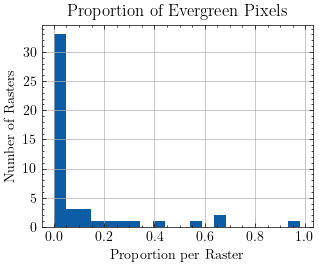

In [6]:
# Compute the proportion of evergreen pixels for every raster and plot it in a kde plot
from slc.features import genera2target, load_raster

proportions = []
for path in tqdm(target_paths):
    raster = load_raster(path, monochrome_as_dataframe=True)
    classification = genera2target(raster)
    proportions.append(classification.map({"deciduous": 0, "evergreen": 1}).mean())

fig, ax = plt.subplots()

prop = pd.Series(proportions)
prop.hist(bins=20, ax=ax)
ax.set_title("Proportion of Evergreen Pixels")
ax.set_xlabel("Proportion per Raster")
ax.set_ylabel("Number of Rasters")

save_fig(fig, f"../reports/figures/ground_truth/{ax.get_title()}.svg")

  0%|          | 0/48 [00:00<?, ?it/s]

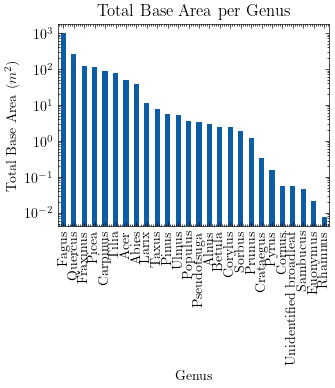

In [7]:
proportions = []
for path in tqdm(target_paths):
    raster = load_raster(path, monochrome_as_dataframe=True)
    proportions.append(raster)

proportions = pd.concat(proportions)
proportions = proportions.fillna(0)

fig, ax = plt.subplots()

ax = proportions.sum(axis=0).sort_values(ascending=False).plot(kind="bar", logy=True)
ax.set_title("Total Base Area per Genus")
ax.set_xlabel("Genus")
ax.set_ylabel("Total Base Area ($m^2$)")

save_fig(fig, f"../reports/figures/ground_truth/{ax.get_title()}.svg")

## Sentinel 2 Data

The Sentinel 2 data corresponding to the target label is generated using the Google Earth Engine. The data is filtered by the boundaries of each area and a specified time range. The data is then reduced to the spatial resolution of the ground truth data and exported to a GeoTIFF file.

We prefer using the Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A dataset, as it is atmospherically corrected and harmonized, shifting data in newer scenes to a range comparable to older scenes. However the Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-1C dataset is available for all Sentinel 2 imagery, starting at 27th of june 2015 while Level-2A data is only available since 28th of march 2017.

To compare the two datasets we use the data which was processed above. We cross validate a random forest classifier with default parameters using Scikit-Learn and the F1 Score. The Sentinel-2 data is averaged over the respective 1 year time windows for each area. All available bands for each product are used:

In [8]:
# Create Level-1C and 2A imagery
from datetime import datetime
from pathlib import Path
from zoneinfo import ZoneInfo

from sklearn.metrics import make_scorer, root_mean_squared_error
from sklearn.model_selection import cross_validate

from slc.data import sentinel_composite

tz = ZoneInfo("CET")

rmse_scorer = make_scorer(root_mean_squared_error)
level_1c_folder = Path("../data/processed/ground_truth/data_1C/")
level_2a_folder = Path("../data/processed/ground_truth/data_2A/")

# Create the 1C composite if it does not exist
level_1c_folder.mkdir(parents=True, exist_ok=True)
for target_path in tqdm(target_paths):
    data_path = level_1c_folder / target_path.name
    year = int(target_path.stem.split("_")[-1])

    if not data_path.exists():
        sentinel_composite(
            target_path_from=target_path,
            data_path_to=data_path,
            time_window=(
                datetime(year, 1, 1, tzinfo=tz),
                datetime(year + 1, 1, 1, tzinfo=tz),
            ),
            level_2a=False,
        )

# Create the 2A composite if it does not exist
level_2a_folder.mkdir(parents=True, exist_ok=True)
for target_path in tqdm(target_paths):
    data_path = level_2a_folder / target_path.name
    year = int(target_path.stem.split("_")[-1])

    if not data_path.exists():
        sentinel_composite(
            target_path_from=target_path,
            data_path_to=data_path,
            time_window=(
                datetime(year, 1, 1, tzinfo=tz),
                datetime(year + 1, 1, 1, tzinfo=tz),
            ),
        )

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [9]:
# Compare it to the baseline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer

from slc.features import load_dataset

f1_scorer = make_scorer(f1_score)

# Load data
target_folder = Path("../data/processed/target/")
data_1c, target = load_dataset(data_path=level_1c_folder, target_path=target_folder)
data_2a, _ = load_dataset(data_path=level_2a_folder, target_path=target_folder)

# Cross validate Random Forest on Level-1C data
rf_classifier = RandomForestClassifier(n_jobs=-1, random_state=42)
level_1c_result = cross_validate(
    rf_classifier, data_1c, target, cv=5, scoring=f1_scorer, n_jobs=-1
)
level_1c_score = level_1c_result["test_score"].mean()

# Cross validate Random Forest on Level-2A data
level_2a_result = cross_validate(
    rf_classifier, data_2a, target, cv=5, scoring=f1_scorer, n_jobs=-1
)
level_2a_score = level_2a_result["test_score"].mean()

f1_scores = pd.DataFrame(
    {
        "Sentinel-2 Data": ["Level-1C", "Level-2A"],
        "F1 Score": [level_1c_score, level_2a_score],
    }
)
f1_scores.to_csv("../reports/ground_truth.csv", index=False)

# Print scores
logger.info(f"Level-1C F1 Score: {level_1c_score}")
logger.info(f"Level-2A F1 Score: {level_2a_score}")

Level-1C F1 Score: 0.028780757130141228
Level-2A F1 Score: 0.13203771063225056


This experiment achieved a significantly higher F1 Score of 0.12 instead of 0.02 when using Level-2A data. As Level-2A data is the preferred product due to its advanced processing, it will be utilized for all future experiments. However, Level-2A data is only available for more recent Sentinel-2 imagery, as noted above. Consequently, the following experiments will employ a one-year time range from 2019 onwards to ensure availability of the Level-2A data and reserve 2018 for the test set.